# Best SVC Model for ASD Detection 
### based on our Target Metric F2-Score

### Import Libraries needed for Modelling

In [1]:
import os
import sys
import pickle

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# import own modules
sys.path.append(
    os.path.join("..", "..")
)  # Adds higher directory to python modules path.
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

### Load the Dataframe
- Calculate the DF or load it form path
- Drop first batch of useless columns
- Set id as an index
- distinguish between numerical and categorical Columns

In [2]:
# path to csv file
path_df = os.path.join("..", "..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(
    columns=[col for col in df.columns if "_obj" in col]
)  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns


### Alter the DF a bit more
- We only take Participants lower equal 5000 (5 Seconds of Fixation Duration per Picture usually the Picture is only shown for 3 Seconds to the Participant)

- Get rid of some Features, which have proven to not give us any value for the Research

In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 44 columns
 -> there are 44 numerical columns
 -> there are 0 categoricals columns


### The Features for Best SVC Model

- I put them in here Hardcoded
- all the selection and Research Work was done in other Notebooks
- I Provide 2 lists of Features which u could choose 1 from
- because Model runs equally good with 11 or 10 Features

In [4]:
df.columns

Index(['asd', 'sp_fix_count', 'sp_fix_duration_ms_total',
       'sp_fix_duration_ms_mean', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to_sp_mean_px_var',
       'dg_sal_first_fixation', 'dg_sal_first_above_0.75*max_rank',
       'dg_sal_first_above_0.9*max_rank', 'dg_sal_mean', 'dg_sal_sum',
       'dg_sal_max', 'dg_sal_weighted_duration_sum',
       'dg_sal_weighted_duration_mean', 'dg_sal_KLD', 'dg_sal_NSS',
       'sam_sal_first_fixation', 'sam_sal_first_above_0.75*max_rank',
       'sam_sal_first_above_0.9*max_rank', 'sam_sal_mean', 'sam_sal_sum',
       'sam_sal_max', 'sam_sal_weighted_duration_sum',
       'sam_sal_weighted_duration_mean', 'sam_sal_KLD', 'sam_sal_NSS',
       'obj_n_fix_face', 'obj_t_abs_on_face', 'obj_t_rel_on_face',
       'obj_n_fix_animate', 'obj_n_fix_inanimate',

In [5]:
# 11 Features List (optional)
feature_list = [
    "sp_fix_duration_ms_total",
    "sp_fix_duration_ms_mean",
    "sp_fix_duration_ms_var",
    "sam_sal_first_fixation",
    "sam_sal_sum",
    "sam_sal_KLD",
    "obj_t_abs_on_background",
    "obj_t_abs_on_animate",
    "obj_n_fix_background",
    "obj_n_fix_inanimate",
    "obj_n_fix_animate",
]

# 10 Features List same as above without "sp_fix_duration_ms_var"

# feature_list = ["sp_fix_duration_ms_total","sp_fix_duration_ms_mean", "sal_first_fixation","sal_sum","sal_KLD", "obj_t_abs_on_background","obj_t_abs_on_animate", "obj_n_fix_background","obj_n_fix_inanimate","obj_n_fix_animate","asd"]

# Model Preparation

### Split into train & test sets

- we defined our own Function "pp.split" and Test Set

- This ensures we can do better Error Analysis on specific Pictures later


In [6]:
# prepare features and target

X = df[feature_list]
y = df.pop("asd")

In [7]:
# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '11' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


### Set Variables and Columns for Pipeline
- define our scoring metric (make_scorer function)
- Set Variables for our Model
- Behavior for saving Models as pickle File later

In [8]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 1


# find numerical and categorical columns
num_cols = X_train.columns[X_train.dtypes != "object"]
cat_cols = X_train.columns[X_train.dtypes == "object"]

### Pipeline & Grid Search CV
- Defining the SVC Pipeline
- Define the Grid Search Grid we use

In [9]:
# The Column Transformer and Operations to do on Columns
# add other transformations at the end if needed
transformer = [
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols),
]

# Add our transformer to a ColumnTransformer Object
preprocessing = ColumnTransformer(transformer, remainder="passthrough")

# The Pipeline for the SVC Model
# Support Vector Classifier: apply scaling / encoding
svc_pipeline = Pipeline(
    [("preprocessor", preprocessing), ("classifier", SVC(probability=True))]
)

# Support Vector Classifier Parameter Grid
param_grid_svc = {
    "classifier__kernel": ["linear", "poly", "rbf", "sigmoid"],  # Kernel types to try
    "classifier__C": [0.1, 1, 10, 100],  # Regularization parameter values
    "classifier__gamma": ["scale", "auto"],  # Gamma parameter for RBF kernel
    "classifier__degree": [
        2,
        3,
        4,
    ],  # Degree of the polynomial kernel (only for poly kernel)
}

### Fit the GridSearchCV with our Gridi and Pipeline
- Define GridSearchCV Model parameters
- Fit on Training Data
- Get the best parameters and estimators


In [10]:
# Create GridSearchCV object
grid_search_svc = GridSearchCV(
    svc_pipeline,
    param_grid=param_grid_svc,
    cv=cv,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)

# Fit the Model
grid_search_svc.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_svc = grid_search_svc.best_params_
best_est_svc = grid_search_svc.best_estimator_
print("Best params for SVC are:", best_params_svc)
print("Best est for SVC are:", best_est_svc)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best params for SVC are: {'classifier__C': 0.1, 'classifier__degree': 4, 'classifier__gamma': 'scale', 'classifier__kernel': 'poly'}
Best est for SVC are: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['sp_fix_duration_ms_total', 'sp_fix_duration_ms_mean',
       'sp_fix_duration_ms_var', 'sam_sal_first_fixation', 'sam_sal_sum',
       'sam_sal_KLD', 'obj_t_abs_on_background', 'obj_t_abs_on_animate',
       'obj_n_fix_background', 'obj_n_fix_inanimate', 'obj_n_fix_animate'],
      dtype='object')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  Index([], dtype='object'))])),
                ('classifier',
    

### Predict on Test and Train Set for Evaluation
- 1 Prediction as Classification - 0 or 1
- 1 Predict Proba - gets back the Probability for a Class

In [11]:
# predict & proba
pred_test = grid_search_svc.predict(X_test)
proba_test = grid_search_svc.predict_proba(X_test)

pred_train = grid_search_svc.predict(X_train)
proba_train = grid_search_svc.predict_proba(X_train)

### Evaluate the Model with own Functions
- em.report gives back a full Evaluation Report
- Learning Curves show the Behaviour of the Model (e.g over/ underfitting)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.740     0.418     0.534      3252
           1      0.593     0.852     0.699      3233

    accuracy                          0.635      6485
   macro avg      0.666     0.635     0.617      6485
weighted avg      0.667     0.635     0.617      6485

f(0.5)-score: 0.631
f(2.0)-score: 0.784

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.774     0.453     0.571       371
           1      0.606     0.864     0.712       361

    accuracy                          0.656       732
   macro avg      0.690     0.659     0.642       732
weighted avg      0.691     0.656     0.641       732

f(0.5)-score: 0.644
f(2.0)-score: 0.796



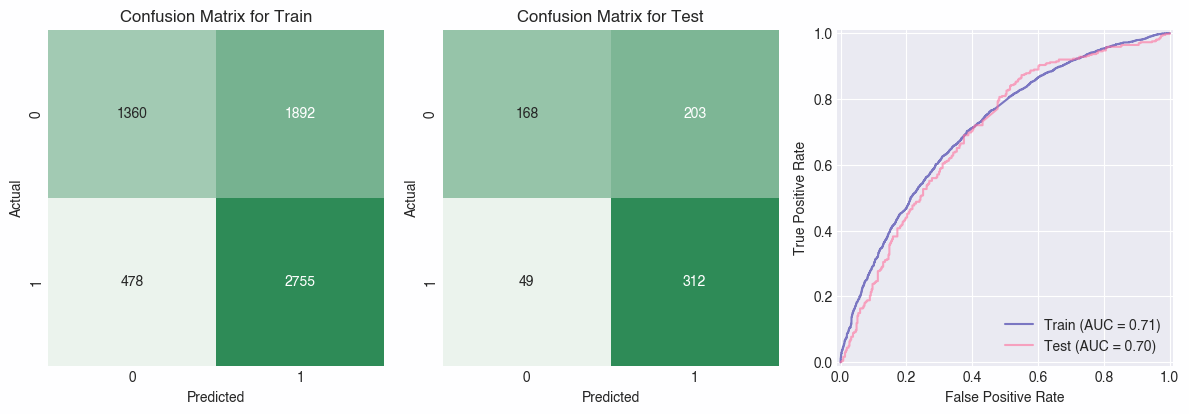

In [12]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

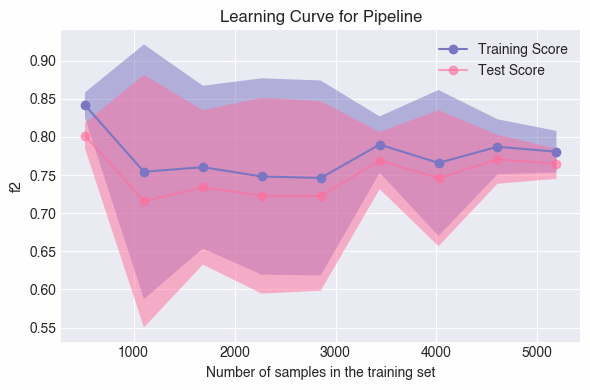

In [13]:
# learning curves - for one model - f2 score
em.learning(best_est_svc, X_train, y_train)

In [14]:
em.model_info(best_est_svc)

### Safe Model as Pickle File

In [15]:
# Define the directory path relative to the current working directory
directory = os.path.join(os.getcwd(), "..", "..", "models", "dev", "SVC")

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the best estimator to a pickle file in the specified directory
file_path = os.path.join(directory, 'SVC_sam_resnet.pickle')
with open(file_path, 'wb') as file:
    pickle.dump(best_est_svc, file)